<a href="https://colab.research.google.com/github/rozan0011/Evolutionweb/blob/master/Tugas_Akhir_GRU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Import semua library yang diperlukan**

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import keras

**Pengujian Google Colab**

1. Import CSV
2. Read CSV
3. Show CSV

In [ ]:
#Import CSV
drive = '/content/drive/MyDrive/Data TA/(Uncleaned1)DataTA_23-27.csv'

#Read CSV
df = pd.read_csv(drive)

#Show CSV
df

,created_at,entry_id,soil1,soil,temperature,humidity
0,2024-10-22T16:07:50+07:00,36205.0,12.0,62.0,24.5,89.0
1,2024-10-22T16:08:13+07:00,36206.0,11.0,58.0,24.5,89.0
2,2024-10-22T16:08:36+07:00,36207.0,12.0,52.0,24.5,89.0
3,2024-10-22T16:09:03+07:00,36208.0,11.0,54.0,24.5,89.0
4,2024-10-22T16:09:27+07:00,36209.0,11.0,52.0,24.5,88.0
...,...,...,...,...,...,...
18406,2024-10-27T12:22:20+07:00,54611.0,8.0,39.0,29.8,64.0
18407,2024-10-27T12:22:42+07:00,54612.0,9.0,39.0,29.8,63.0
18408,2024-10-27T12:23:05+07:00,54613.0,8.0,40.0,29.8,62.0
18409,2024-10-27T12:23:27+07:00,54614.0,10.0,38.0,29.8,62.0


# New Section

**Preprocessing data**
1. Penghapusan time zone
2. Penghapusan data kosong
3. Data labeling
4. Penentuan Feature dan label
5. Normalisasi


In [ ]:
#Penghapusan Time Zone
df['created_at'] = pd.to_datetime(df['created_at']).dt.tz_localize(None)
df.set_index('created_at', inplace=True)

In [ ]:
df.isna().sum()

,0
entry_id,1
soil1,1
soil,1
temperature,15
humidity,16


In [ ]:
#Penghapusan data kosong menggunakan backfill
df.backfill(inplace=True)
df.isna().sum()

<ipython-input-34-e8d44248fb06>:2: FutureWarning: DataFrame.backfill/Series.backfill is deprecated. Use DataFrame.bfill/Series.bfill instead
  df.backfill(inplace=True)


,0
entry_id,1
soil1,1
soil,1
temperature,0
humidity,1


In [ ]:
df.dropna(inplace=True)
df.isna().sum()

,0
entry_id,0
soil1,0
soil,0
temperature,0
humidity,0
need_water,0


In [ ]:
#Data labeling using Label Encodign
# Define thresholds
soil_threshold = 30

# Use vectorized operations to label 'need_water'
df['need_water'] = (df['soil1'] < soil_threshold).astype(int)

# Check the first few rows
print(df.head())

print(df['need_water'].value_counts())

                     entry_id  soil1  soil  temperature  humidity  need_water
created_at                                                                   
2024-10-22 16:07:50   36205.0   12.0  62.0         24.5      89.0           1
2024-10-22 16:08:13   36206.0   11.0  58.0         24.5      89.0           1
2024-10-22 16:08:36   36207.0   12.0  52.0         24.5      89.0           1
2024-10-22 16:09:03   36208.0   11.0  54.0         24.5      89.0           1
2024-10-22 16:09:27   36209.0   11.0  52.0         24.5      88.0           1
need_water
1    11858
0     6553
Name: count, dtype: int64


In [ ]:
#data feature and label asign
features = df[['soil1','temperature','humidity']]
label = df['need_water']

In [ ]:
#Normalisasi feature
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
features_scaled = scaler.fit_transform(features)

**Pengujian Algoritma GRU mengguanakn Confussion Matrix**
1. Buat sequence
2. Train-testing data split7
3. Pembuatan model GRU
4. Compile model
5. Training model
6. Evaluasi test data
7. Pembuatan prediksi
8. Confusion Matrix

In [ ]:
features_scaled = scaler.fit_transform(features)

# Fungsi untuk membuat dataset dengan timestep
def create_dataset(data, label, time_steps=1):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:(i + time_steps)])
        y.append(label[i + time_steps])
    return np.array(X), np.array(y)

# Menentukan jumlah timestep
time_steps = 3

# Membuat dataset dengan timestep
X, y = create_dataset(features_scaled, label, time_steps)

# Membagi data menjadi train dan test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Print bentuk X_train dan y_train
print("Shape of X_train:", X_train.shape)
print("Shape of y_train:", y_train.shape)

<ipython-input-38-e831bdad23b0>:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(label[i + time_steps])


Shape of X_train: (14726, 3, 3)
Shape of y_train: (14726,)


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense


model = Sequential()

# Layer pertama GRU
model.add(GRU(16, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))

# Layer kedua GRU
model.add(GRU(8, return_sequences=False))

# Output layer
model.add(Dense(1, activation='sigmoid'))

# Compile Model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train Model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=20, batch_size=32)


Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


461/461 ━━━━━━━━━━━━━━━━━━━━ 41s 7ms/step - accuracy: 0.7769 - loss: 0.4163 - val_accuracy: 0.9927 - val_loss: 0.0218
Epoch 2/20
461/461 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.9946 - loss: 0.0203 - val_accuracy: 0.9826 - val_loss: 0.0597
Epoch 3/20
461/461 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9940 - loss: 0.0178 - val_accuracy: 0.9919 - val_loss: 0.0179
Epoch 4/20
461/461 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9945 - loss: 0.0168 - val_accuracy: 0.9927 - val_loss: 0.0161
Epoch 5/20
461/461 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9956 - loss: 0.0138 - val_accuracy: 0.9978 - val_loss: 0.0093
Epoch 6/20
461/461 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.9964 - loss: 0.0129 - val_accuracy: 0.9970 - val_loss: 0.0090
Epoch 7/20
461/461 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.9959 - loss: 0.0116 - val_accuracy: 0.9943 - val_loss: 0.0112
Epoch 8/20
461/461 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9958 - loss: 0.0141 - val_accuracy: 0.9976 - val

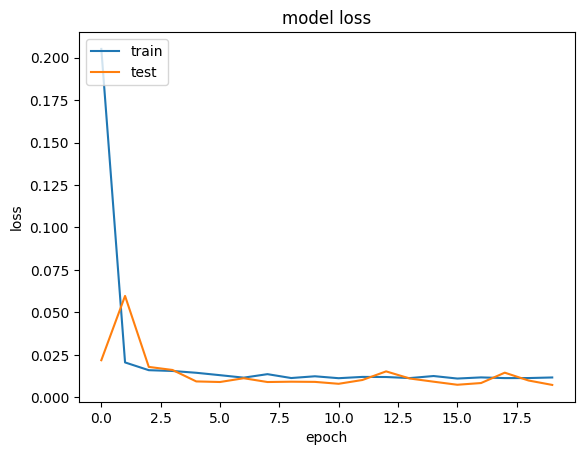

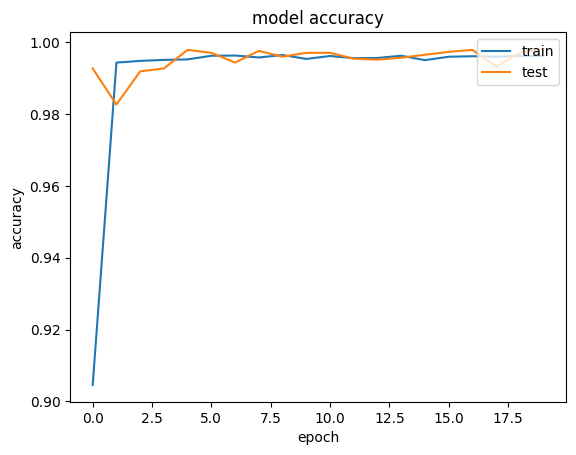

In [ ]:
import matplotlib.pyplot as plt

plt.rcParams['figure.dpi'] = 100

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [ ]:
#classification report
from sklearn.metrics import classification_report

# Make predictions
y_pred = model.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int)

# Generate classification report
report = classification_report(y_test, y_pred_binary)
print(report)

116/116 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1307
           1       1.00      1.00      1.00      2375

    accuracy                           1.00      3682
   macro avg       1.00      1.00      1.00      3682
weighted avg       1.00      1.00      1.00      3682



116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
[[1302    5]
 [   2 2373]]


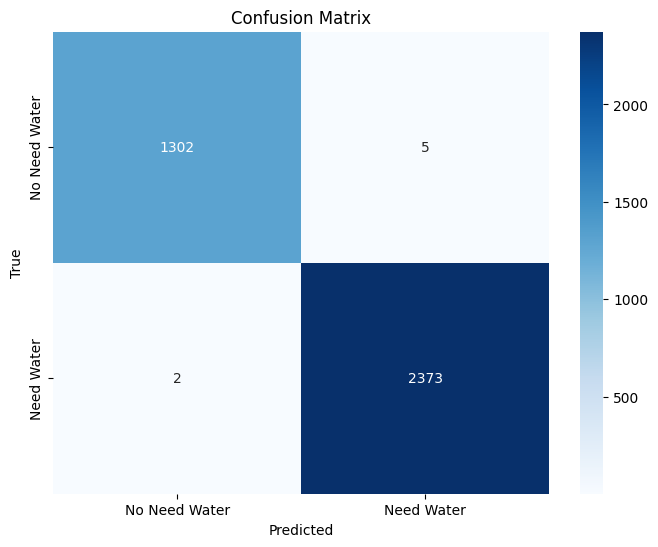

In [ ]:
#confusion matrix
from sklearn.metrics import confusion_matrix

# Make predictions
y_pred = model.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int)

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred_binary)
print(cm)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Need Water', 'Need Water'], yticklabels=['No Need Water', 'Need Water'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

**Perbandingan Model**
Variable:
- Unit Neuron
- Jumlah Epoch
- Batch Size

Pengukuruan
- Precision
- Recall
- F1 Score

In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import precision_score, recall_score, f1_score
from keras.models import Sequential
from keras.layers import GRU, Dense
from sklearn.model_selection import train_test_split


# Function to create and train the model
def create_model(units, epochs, batch_size):
    model = Sequential()
    model.add(GRU(units, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
    model.add(GRU(units, return_sequences=False))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, batch_size=batch_size, verbose=0)
    return model

# List of parameters to test
units_list = [32, 64]  # Number of neurons
epochs_list = [10, 20]  # Number of epochs
batch_sizes = [16, 32, 64]  # Batch sizes

# Store results
results = []

# Iterate over all combinations of parameters
for units in units_list:
    for epochs in epochs_list:
        for batch_size in batch_sizes:
            model = create_model(units, epochs, batch_size)
            # Make predictions
            y_pred = (model.predict(X_test) > 0.5).astype("int32")  # Convert probabilities to binary predictions

            # Calculate precision, recall, and F1 score
            precision = precision_score(y_test, y_pred)
            recall = recall_score(y_test, y_pred)
            f1 = f1_score(y_test, y_pred)

            # Append results
            results.append({
                'Units': units,
                'Epochs': epochs,
                'Batch Size': batch_size,
                'Precision': precision,
                'Recall': recall,
                'F1 Score': f1
            })

# Create a DataFrame from the results
results_df = pd.DataFrame(results)

# Display the results
print(results_df)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


116/116 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


116/116 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


116/116 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


116/116 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


116/116 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


116/116 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


116/116 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


116/116 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


116/116 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


116/116 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


116/116 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


116/116 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
    Units  Epochs  Batch Size  Precision    Recall  F1 Score
0      32      10          16   0.998736  0.997895  0.998315
1      32      10          32   0.997055  0.997895  0.997475
2      32      10          64   0.999577  0.994947  0.997257
3      32      20          16   0.995804  0.999158  0.997478
4      32      20          32   0.997897  0.999158  0.998527
5      32      20          64   0.997895  0.997895  0.997895
6      64      10          16   0.998737  0.998737  0.998737
7      64      10          32   0.999578  0.997895  0.998736
8      64      10          64   0.999577  0.995368  0.997468
9      64      20          16   0.998737  0.998737  0.998737
10     64      20          32   0.998735  0.997053  0.997893
11     64      20          64   0.999577  0.994526  0.997045
